# DPAA Identification Time Series History and Forecast
John Bonfardeci<br/>
2021-02-02

In [1]:
# Load Dependencies
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.arima.api as tsf
import statsmodels.stats.outliers_influence as oi
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.decomposition import PCA

import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt

import re
import numpy as np
import seaborn as sns

In [2]:
def get_lags(df, target_col, nlags=1):
    lags = df.copy()
    for i in range(1, nlags+1):
        lag = lags.shift(i)
        cols = lags.columns.values.tolist()
        lags = pd.concat([lags, lag[target_col]], 1)
        cols.append(str.format('lag_{0}', i))
        lags.columns = cols
    
    return lags

In [17]:
# 12 months of N/A values from 1/1/2018 - 12/31/2018 were added to the CSV for forecasting.
data = pd.read_csv('./dpaa_icf_20210202_counts.csv', parse_dates=['Monthly'])
data.set_index('Monthly', inplace=True)
#data.index = pd.PeriodIndex(data.Monthly, freq='M')
#data.drop(['Monthly'], 1, inplace=True)
data.tail(20)

,IdentifiedCount
Monthly,
2020-06-01,12.0
2020-07-01,4.0
2020-08-01,5.0
2020-09-01,22.0
2020-10-01,4.0
2020-11-01,11.0
2020-12-01,18.0
2021-01-01,3.0
2021-02-01,NaN


In [4]:
# Drop the last N rows of the data for the training set. 
# The last month in the data is significantly lower than previous months
# due incomplete count or an outlier which will throw off any forecast.
train = data.drop(data.tail(20).index, inplace=False)
train.tail(5)

,IdentifiedCount
Monthly,
2020-01-01,5.0
2020-02-01,3.0
2020-03-01,9.0
2020-04-01,31.0
2020-05-01,11.0


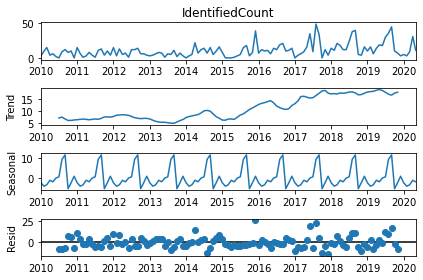

In [5]:
season = sm.tsa.seasonal_decompose(x=train.IdentifiedCount)
season_fig = season.plot()

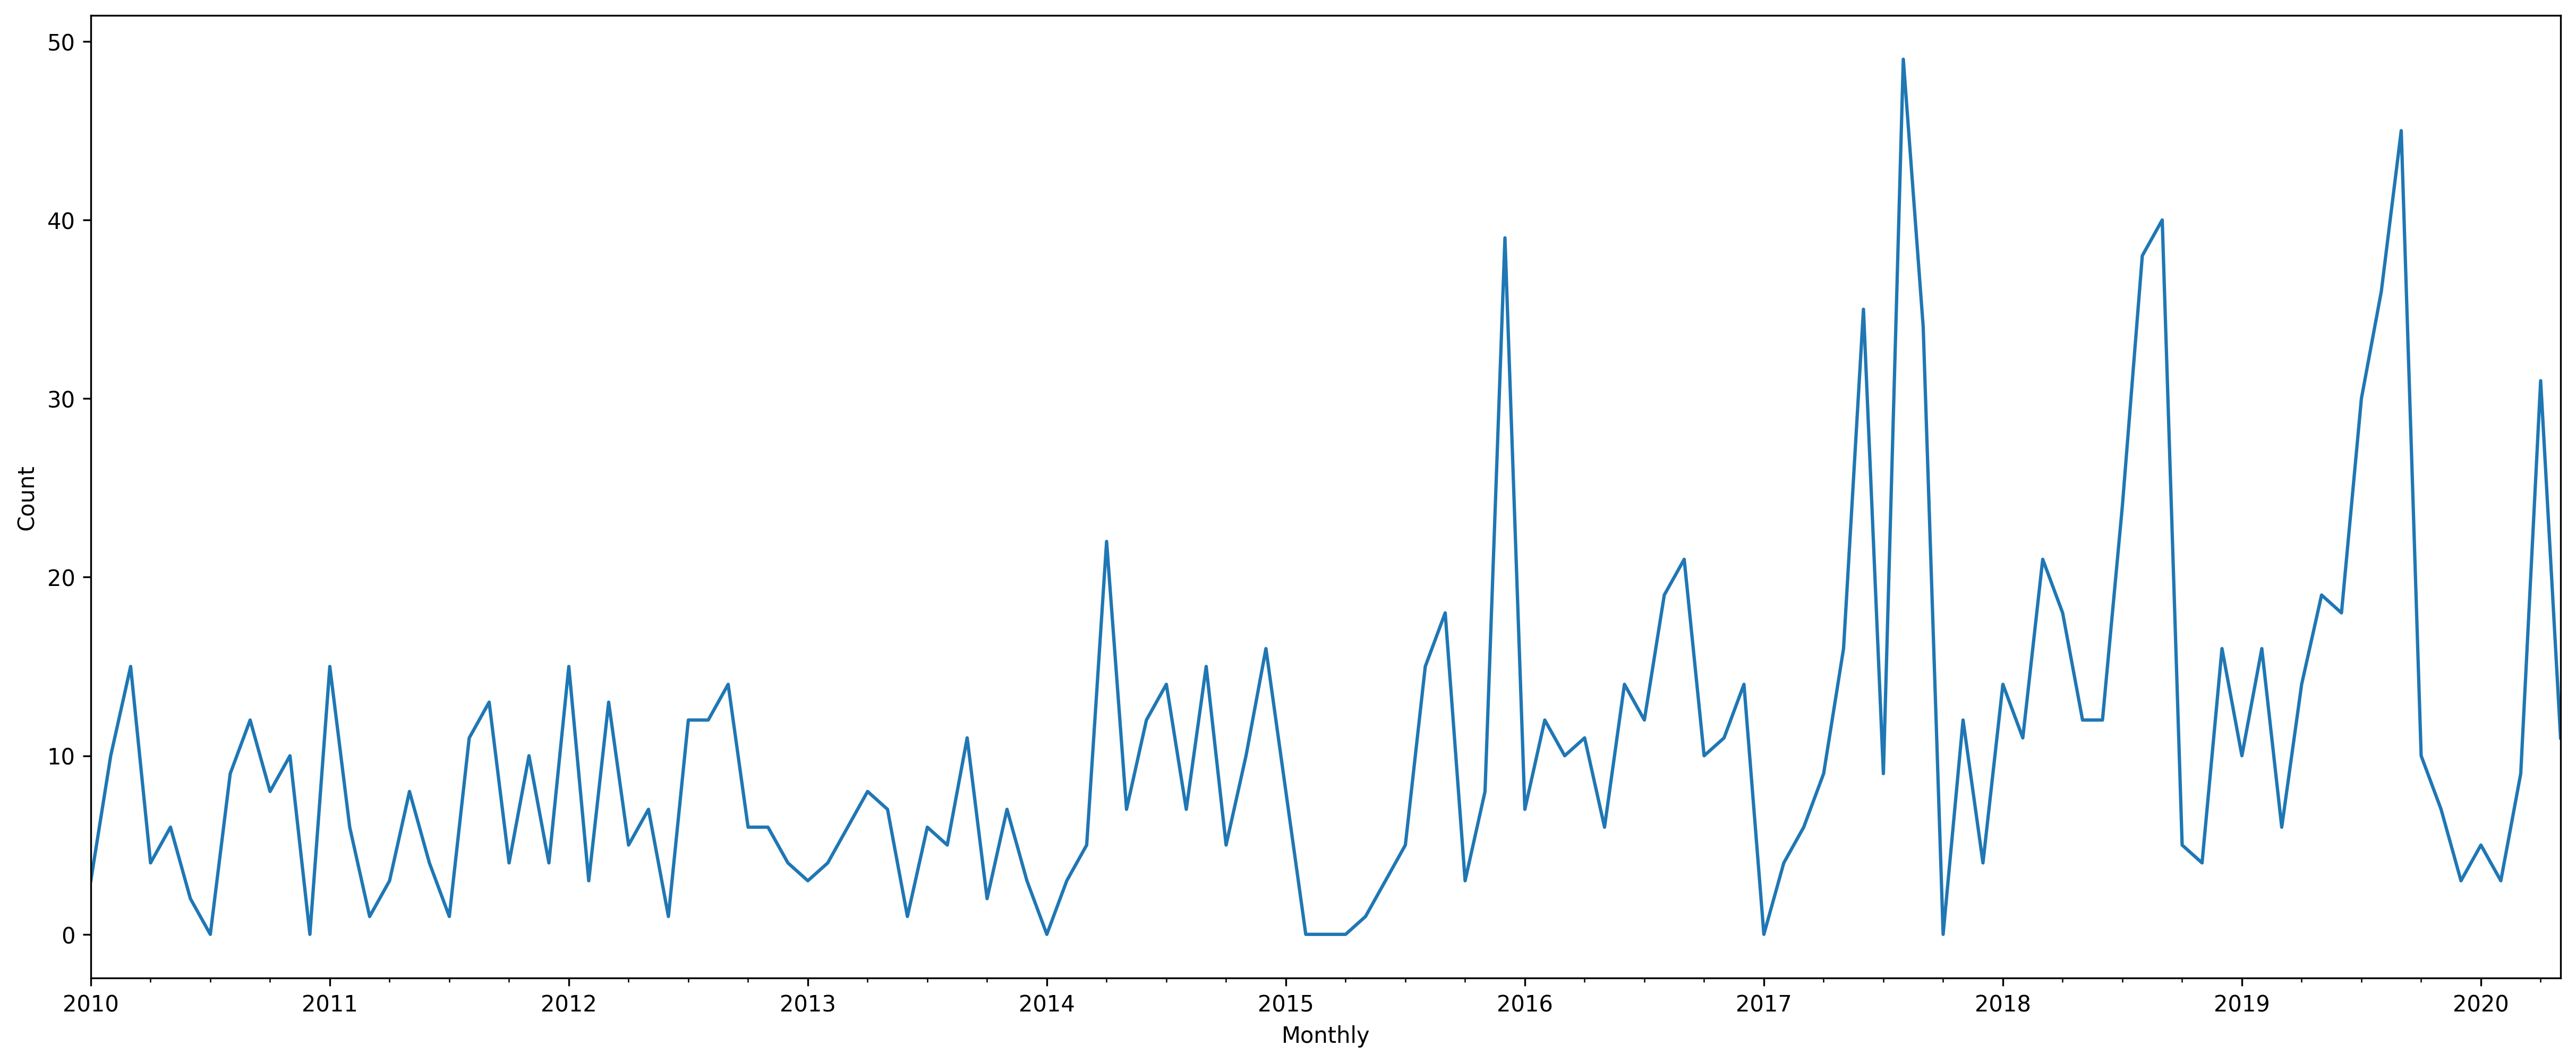

In [6]:
# Raw time series plot
series = pd.Series(train.IdentifiedCount)
ax = plt.figure(figsize=(20,8), dpi=300).add_subplot(111)
plt.ylabel('Count')
plt.xlabel('Year-Month')
splot = series.plot()

In [7]:
# Calculate outliers from quartiles.
q1, q2, q3, q4 = train.IdentifiedCount.describe()[4:8]
iqr = q3-q1
lower_limit = q1-1.5*iqr
upper_limit = q3+1.5*iqr
print("Max: %i. Median: %i. Outliers are > %i or < %i" % (q4, q2, upper_limit, lower_limit))

Max: 49. Median: 9. Outliers are > 29 or < -11


In [8]:
train['Outlier'] = list(map(lambda n: 1 if n > upper_limit else 0, train.IdentifiedCount))
train.query('Outlier == 1')

,IdentifiedCount,Outlier
Monthly,,
2015-12-01,39.0,1
2017-06-01,35.0,1
2017-08-01,49.0,1
2017-09-01,34.0,1
2018-08-01,38.0,1
2018-09-01,40.0,1
2019-07-01,30.0,1
2019-08-01,36.0,1
2019-09-01,45.0,1


In [9]:
# Fit and find significant lags with p-values (P>|t|) < 0.05
lags = get_lags(train, 'IdentifiedCount', nlags=12)
lag_cols = [col for col in lags.columns.values.tolist() if re.search(r'^lag_', col)]
formula = str.format('IdentifiedCount ~ {0}', ' + '.join(lag_cols))
fit_lags = smf.poisson(formula, lags).fit()
fit_lags.summary()

Optimization terminated successfully.
         Current function value: 4.397410
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:        IdentifiedCount   No. Observations:                  113
Model:                        Poisson   Df Residuals:                      100
Method:                           MLE   Df Model:                           12
Date:                Tue, 23 Feb 2021   Pseudo R-squ.:                  0.2437
Time:                        15:00:39   Log-Likelihood:                -496.91
converged:                       True   LL-Null:                       -657.03
Covariance Type:            nonrobust   LLR p-value:                 2.619e-61
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7179      0.077     22.211      0.000       1.566       1.869
lag_1          0.0115      0.003      3.961      0.000       0.006       0.017
lag_2          0.0076      0.003      2.343      0.019       0.001       0.014
lag_3          0.0040      0.003      1.169      0.242      -0.003       0.011
lag_4         -0.0080      0.004     -2.119      0.034      -0.015      -0.001
lag_5         -0.0042      0.004     -1.146      0.252      -0.011       0.003
lag_6         -0.0060      0.003     -1.740      0.082      -0.013       0.001
lag_7          0.0059      0.003      1.865      0.062      -0.000       0.012
lag_8          0.0049      0.003      1.646      0.100      -0.001       0.011
lag_9          0.0035      0.003      1.136      0.256      -0.003       0.009
lag_10        -0.0020      0.003     -0.681      0.496      -0.008       0.004
lag_11         0.0102      0.003      3.552      0.000       0.005       0.016
lag_12         0.0301      0.003     10.779      0.000       0.025       0.036
==============================================================================
"""

In [10]:
# Fit the initial model.
drop_lags = []
sig_lags = [x for x in range(1,11) if x not in drop_lags]
mod = SARIMAX(endog=train.IdentifiedCount, freq='MS',\
            order=(0,1,1), \
            seasonal_order=(0,1,1,12),
            exog=train.Outlier)

res = mod.fit(disp=False)
res.summary()

/home/jbonfardeci/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    IdentifiedCount   No. Observations:                  125
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -359.908
Date:                            Tue, 23 Feb 2021   AIC                            727.815
Time:                                    15:00:39   BIC                            738.689
Sample:                                01-01-2010   HQIC                           732.227
                                     - 05-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Outlier       23.5623      1.827     12.895      0.000      19.981      27.144
ma.L1         -0.8977      0.061    -14.762      0.000      -1.017      -0.779
ma.S.L12      -0.9308      0.299     -3.118      0.002      -1.516      -0.346
sigma2        29.4166      8.212      3.582      0.000      13.322      45.511
===================================================================================
Ljung-Box (L1) (Q):                   2.52   Jarque-Bera (JB):                 2.15
Prob(Q):                              0.11   Prob(JB):                         0.34
Heteroskedasticity (H):               2.21   Skew:                             0.32
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

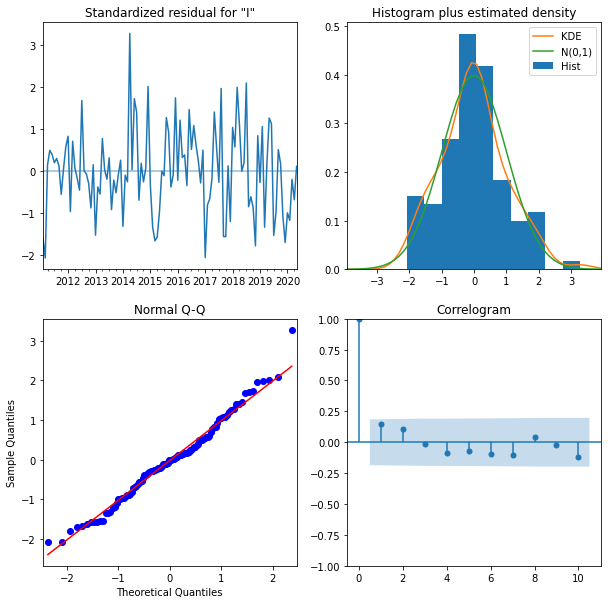

In [11]:
diag = res.plot_diagnostics()
diag.set_figheight(10)
diag.set_figwidth(10)

In [12]:
res.mae

4.735840041534239

In [13]:
# Combine fitted with forecast, except for first 12 lags, since this is annual seasonal model.
yhat = [None for n in range(0,12)] + list(res.fittedvalues[12:])
exog_forecast = np.array( [np.array([0]) for i in range(22)] )
forecast  = res.predict(start=127, end=146, exog=exog_forecast)

yhat.extend(forecast)
yhat = list(map(lambda y: 0 if y != None and y < 0 else y, yhat))
data['Yhat'] = yhat

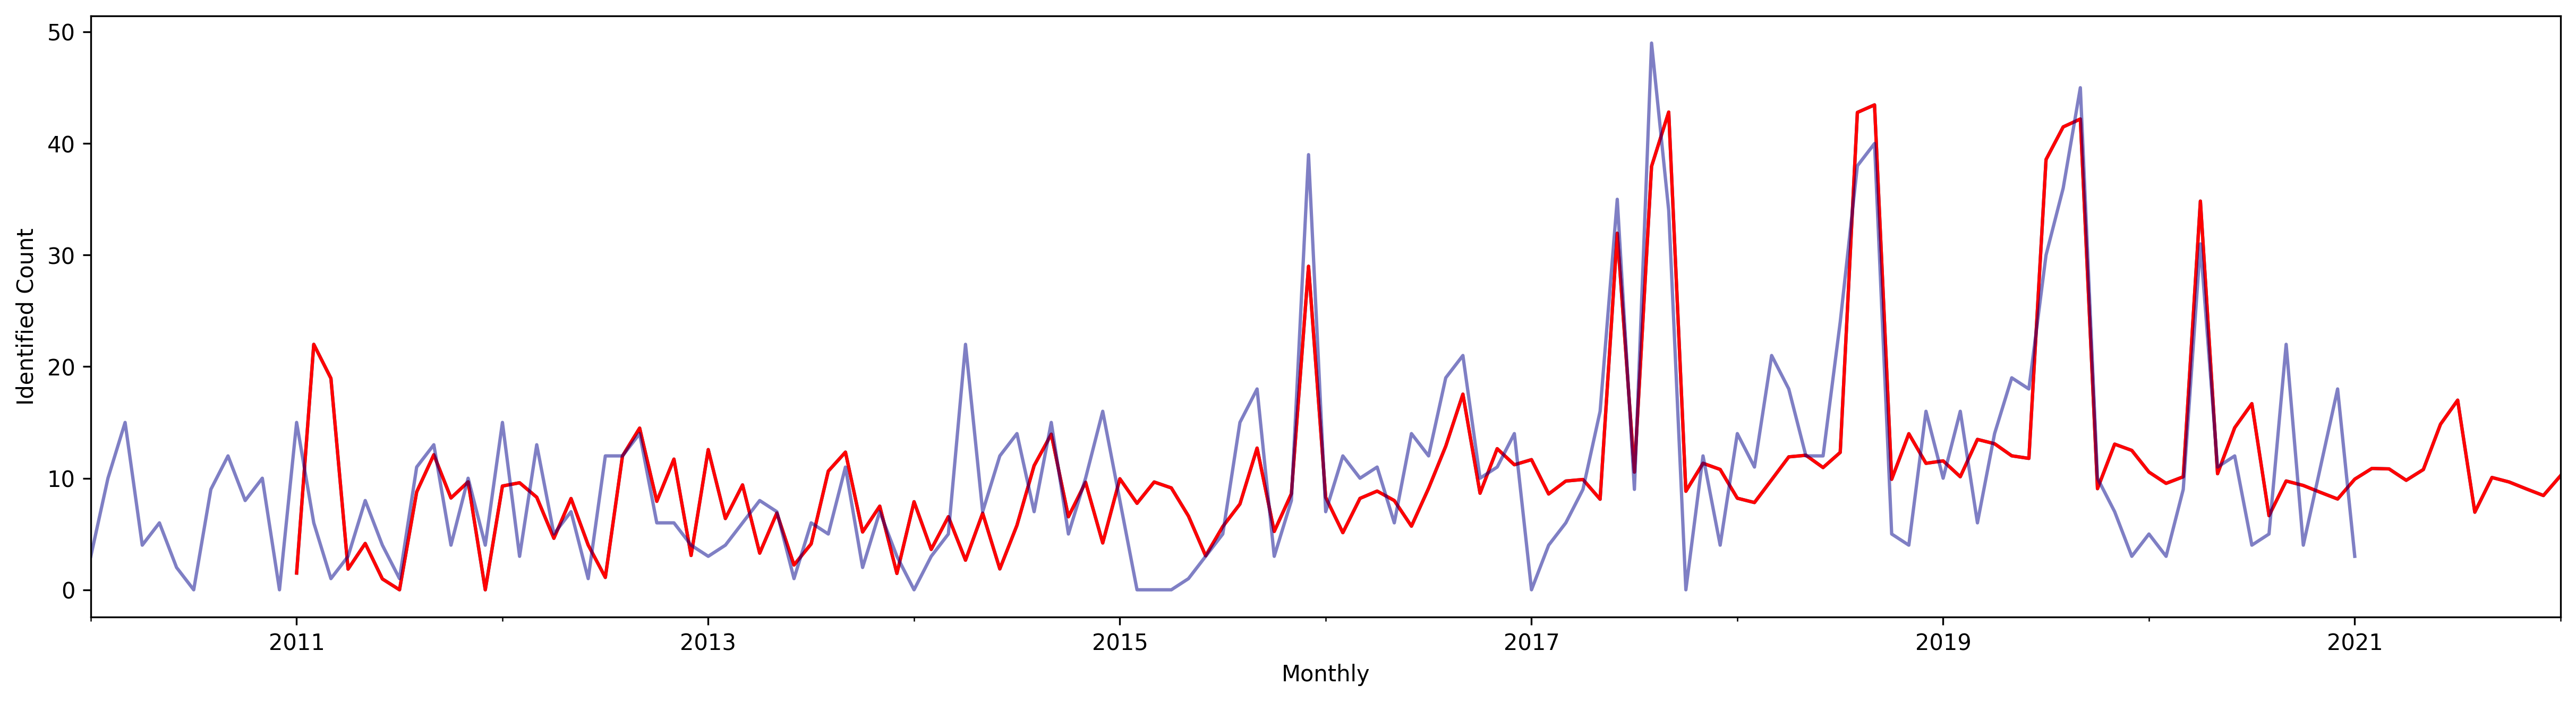

In [14]:
series_actual = pd.Series(data.IdentifiedCount)
series_forecast = pd.Series(data.Yhat)
ax = plt.figure(figsize=(20,5), dpi=300).add_subplot(111)
series_forecast.plot(ax=ax, style='-')
plt.ylabel('Identified Count')
plt.xlabel('Year-Month')
series_forecast.plot(color='red')
splot = series_actual.plot(color='darkblue', alpha=0.5)

In [15]:
perc_errors = []
data['Residual'] = 0
data['PercentResidual'] = 0
for ix, row in data.iterrows():
    actual = row.IdentifiedCount
    yhat = row.Yhat
    if pd.isnull(actual) or pd.isnull(yhat):
        continue      
    pct = 0
    abs_err = np.abs(yhat - actual)
    if actual > 0:
        pct = abs_err/actual
        
    data.at[ix, 'PercentResidual'] = pct
    data.at[ix, 'Residual'] = abs_err
    perc_errors.append(pct)
    
mape = np.mean(perc_errors)*100
print(str.format('MAPE: {0:.2f}%', mape))

MAPE: 75.37%
